In [ ]:
# Create labeled dataset for unlabeled data (the label is the camera index)
# Create data loader using this unlabeled data that has appropriate transforms

In [46]:
import os
import random

from PIL import Image

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.optim as optim 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models

In [45]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

## Dataset Creation for Self-Supervised Learning Task 1: Camera View Prediction



In [146]:
# Constants taken from data_helper.py
NUM_SAMPLE_PER_SCENE = 126
NUM_IMAGE_PER_SAMPLE = 6
image_names = [
    'CAM_FRONT_LEFT.jpeg',
    'CAM_FRONT.jpeg',
    'CAM_FRONT_RIGHT.jpeg',
    'CAM_BACK_LEFT.jpeg',
    'CAM_BACK.jpeg',
    'CAM_BACK_RIGHT.jpeg',
    ]

# Unlabeled scenes
val_unlabeled_scene_index = np.arange(80,106)
train_unlabeled_scene_index = np.arange(80)

# Image folder
image_folder = '/scratch/brs426/data'
first_dim = 'image'

# Transforms
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
normalize_patches = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                           torchvision.transforms.Normalize((0.5206, 0.5748, 0.6066), (0.3140, 0.3253, 0.3349))])
cropped = torchvision.transforms.Compose([torchvision.transforms.RandomCrop(100),
                                          torchvision.transforms.ToTensor(), 
                                          torchvision.transforms.Normalize((0.5565, 0.6024, 0.6324), (0.3353, 0.3378, 0.3389))])

# Also need to include normalization for color channels and cropping
# Cropping should be done up to [:,:175,:] for all views

# Need to recalculate for patches
# Normalization for patches:
# Mean: [0.5206, 0.5748, 0.6066]
# STD: [0.3140, 0.3253, 0.3349]

# Over full images
# Normalization for entire image
# Mean: [0.5565, 0.6024, 0.6324]
# STD: [0.3353, 0.3378, 0.3389]

In [147]:
# Based off of the UnlabeledDataset in data_helper.py
class CameraPredictionDataset(torch.utils.data.Dataset):
    def __init__(self, image_folder, scene_index, transform, crop_height=None):
        """
        Args:
            image_folder (string): the location of the image folder
            scene_index (list): a list of scene indices for the unlabeled data 
            first_dim ({'sample', 'image'}):
                'sample' will return [batch_size, NUM_IMAGE_PER_SAMPLE, 3, H, W]
                'image' will return [batch_size, 3, H, W] and the index of the camera [0 - 5]
                    CAM_FRONT_LEFT: 0
                    CAM_FRONT: 1
                    CAM_FRONT_RIGHT: 2
                    CAM_BACK_LEFT: 3
                    CAM_BACK.jpeg: 4
                    CAM_BACK_RIGHT: 5
            transform (Transform): The function to process the image
        """

        self.image_folder = image_folder
        self.scene_index = scene_index
        self.transform = transform
        self.crop_height = crop_height

        assert first_dim in ['sample', 'image']
        self.first_dim = first_dim

    def __len__(self):
        return self.scene_index.size * NUM_SAMPLE_PER_SCENE * NUM_IMAGE_PER_SAMPLE
    
    def __getitem__(self, index):
        scene_id = self.scene_index[index // (NUM_SAMPLE_PER_SCENE * NUM_IMAGE_PER_SAMPLE)]
        sample_id = (index % (NUM_SAMPLE_PER_SCENE * NUM_IMAGE_PER_SAMPLE)) // NUM_IMAGE_PER_SAMPLE
        image_name = image_names[index % NUM_IMAGE_PER_SAMPLE]

        image_path = os.path.join(self.image_folder, f'scene_{scene_id}', f'sample_{sample_id}', image_name) 

        image = Image.open(image_path)
        image = self.transform(image)
        # Remove car parts
        if self.crop_height is not None:
            image = image[:,:self.crop_height,:]
        # Return image and camera view
        return image, index % NUM_IMAGE_PER_SAMPLE

#### Create Dataset

In [148]:
train_cropped_ds = CameraPredictionDataset(image_folder, train_unlabeled_scene_index, cropped)
val_cropped_ds = CameraPredictionDataset(image_folder, val_unlabeled_scene_index, cropped)
#unnormalized_ds = CameraPredictionDataset(image_folder, unlabeled_scene_index, transform, crop_height=175)

#### Create DataLoader

In [149]:
# Create Data Loader
camera_dataloader = torch.utils.data.DataLoader(normalized_ds, batch_size=64,
                        shuffle=True, num_workers=8)
train_cropped_camera_dataloader = torch.utils.data.DataLoader(train_cropped_ds, batch_size=64, shuffle=True, num_workers=8)
val_cropped_camera_dataloader = torch.utils.data.DataLoader(val_cropped_ds, batch_size=64, shuffle=True, num_workers=4)

#### Train logic

In [150]:
# Train logic, return average loss over training set after each epoch
def train(model, device, train_loader, optimizer, epoch, log_interval = 250):
    # Set model to training mode
    model.train()
    
    # Number correct for accuracy
    num_correct = 0
    
    # Train loss
    train_loss = 0
    
    # Loop through examples
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # Send data and target to device
        data, target = data.to(device), target.to(device)
        
        # Zero out optimizer
        optimizer.zero_grad()
        
        # Pass data through model
        output = model(data)
        predictions = torch.argmax(output, 1)
        num_correct += torch.sum(predictions == target).item()
        
        # Compute the loss
        loss = F.cross_entropy(output, target)
        train_loss += loss.item()
        
        # Backpropagate loss
        loss.backward()
        
        # Make a step with the optimizer
        optimizer.step()
        
        # Print loss (uncomment lines below once implemented)
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    
    
    # Average train loss
    average_train_loss = train_loss / len(train_loader)
    # Print loss (uncomment lines below once implemented)
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        average_train_loss, num_correct, len(train_loader.dataset),
        100. * num_correct / len(train_loader.dataset)))

In [ ]:
# Define test method
def test(model, device, test_loader):
    # Set model to evaluation mode
    model.eval()
    # Variable for the total loss 
    test_loss = 0
    # Counter for the correct predictions
    num_correct = 0
    
    # don't need autograd for eval
    with torch.no_grad():
        # Loop through data points
        for data, target in test_loader:
            pass # remove once implemented
        
            # Send data to device
            data, target = data.to(device), target.to(device)
            
            # Pass data through model
            output = model(data)
            
            # Compute the negative log likelihood loss with reduction='sum' and add to total test_loss
            loss = F.cross_entropy(output, target, reduction='sum')
            test_loss += loss.item()
            
            # Get predictions from the model for each data point
            predictions = torch.argmax(output, 1)

            # Add number of correct predictions to total num_correct 
            num_correct += torch.sum(predictions == target).item()
            
    
    # Compute the average test_loss
    # avg_test_loss = TODO
    avg_test_loss = test_loss / len(test_loader.dataset)
    
    # Print loss (uncomment lines below once implemented)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        avg_test_loss, num_correct, len(test_loader.dataset),
        100. * num_correct / len(test_loader.dataset)))
    
    return avg_test_loss

#### Model Architecture

In [151]:
# Create resnet-based model
# Resnet outputs unnormalized scores for 1000 class classification problem
class ResNet34Model(nn.Module):
    def __init__(self, num_classes, hidden_size):
        super(ResNet34Model, self).__init__()
        self.resnet = models.resnet34()
        self.fc1 = nn.Linear(1000, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = F.relu(self.resnet(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [152]:
# Load in resnet34 model
res34 = ResNet34Model(6, 256).to(device)

# Optimizer
optimizer = optim.Adam(res34.parameters(), lr=3e-4)

In [153]:
best_val_loss = None
save_path = "./ben_models/resnet34_100x100_patch_camera_view_SSL_checkpoint.p"
epochs = 20
for epoch in range(1, epochs + 1):
    # Train model
    train(res34, device, train_cropped_camera_dataloader, optimizer, epoch)
    val_loss = test(res34, device, val_cropped_camera_loader)
    # Save model
    if best_train_loss is None:
        torch.save({'model_state_dict': res34.state_dict(),
                   'optimizer_state_dict': optimizer.state_dict(),
                   'loss': val_loss}, save_path)
        best_val_loss = val_loss

Train Epoch: 1 [0/80136 (0%)]	Loss: 1.782864
Train Epoch: 1 [16000/80136 (20%)]	Loss: 0.986475
Train Epoch: 1 [32000/80136 (40%)]	Loss: 0.568187
Train Epoch: 1 [48000/80136 (60%)]	Loss: 0.430573
Train Epoch: 1 [64000/80136 (80%)]	Loss: 0.414850
Train Epoch: 1 [80000/80136 (100%)]	Loss: 0.412552

Train set: Average loss: 0.5581, Accuracy: 62825/80136 (78%)

Train Epoch: 2 [0/80136 (0%)]	Loss: 0.291457
Train Epoch: 2 [16000/80136 (20%)]	Loss: 0.281761
Train Epoch: 2 [32000/80136 (40%)]	Loss: 0.404539
Train Epoch: 2 [48000/80136 (60%)]	Loss: 0.299064
Train Epoch: 2 [64000/80136 (80%)]	Loss: 0.201236
Train Epoch: 2 [80000/80136 (100%)]	Loss: 0.159726

Train set: Average loss: 0.2897, Accuracy: 71578/80136 (89%)

Train Epoch: 3 [0/80136 (0%)]	Loss: 0.355556
Train Epoch: 3 [16000/80136 (20%)]	Loss: 0.262803
Train Epoch: 3 [32000/80136 (40%)]	Loss: 0.080651
Train Epoch: 3 [48000/80136 (60%)]	Loss: 0.185926
Train Epoch: 3 [64000/80136 (80%)]	Loss: 0.252522
Train Epoch: 3 [80000/80136 (100%)]	L

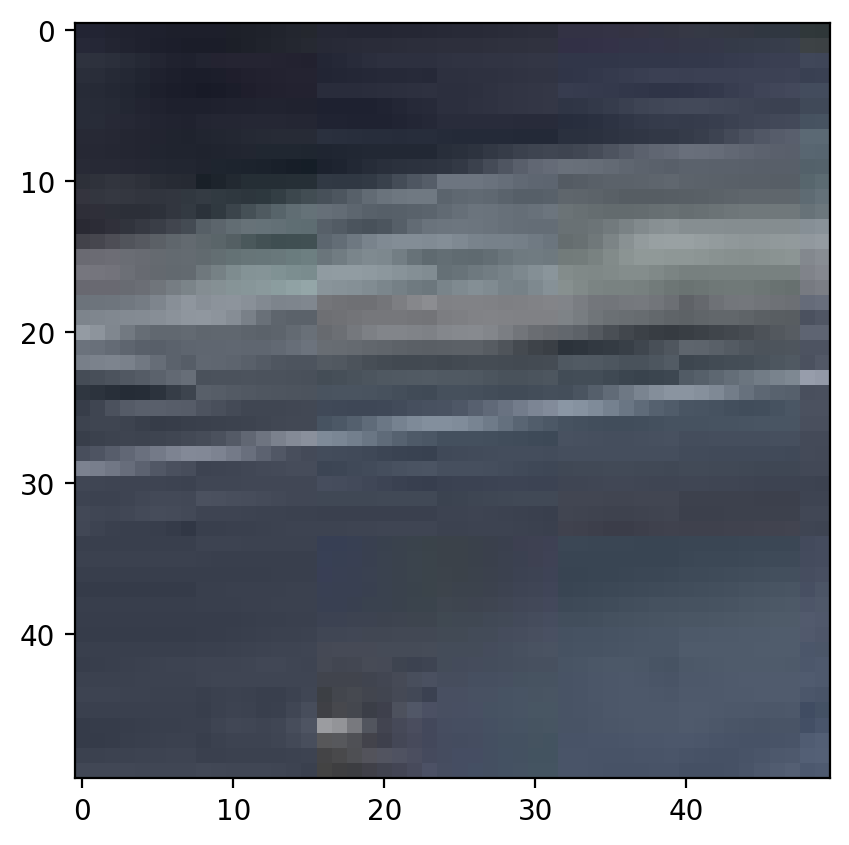

In [141]:
plt.imshow(cropped_ds[6][0].numpy().transpose(1,2,0))

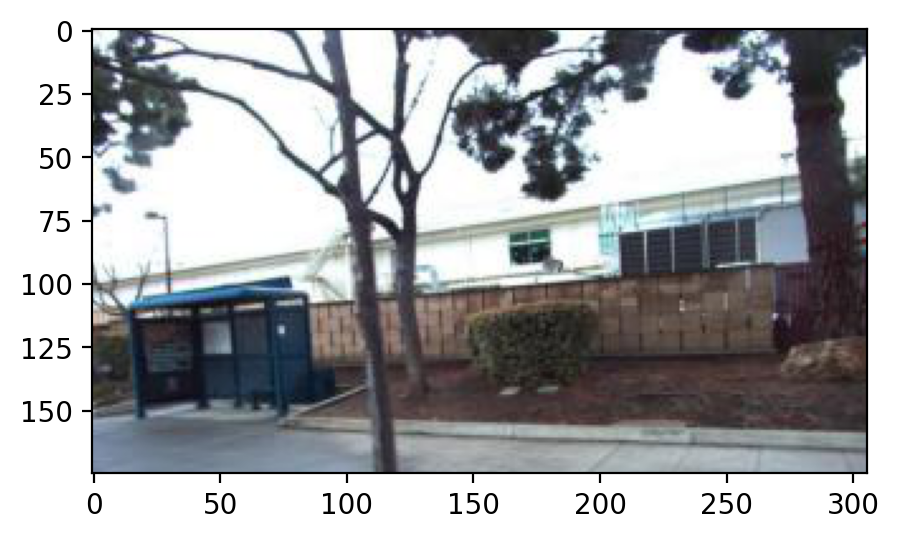

torch.Size([3, 175, 306])

0.5397074

0.5527765

0.53785455

before <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=306x256 at 0x2B1AB6975F40>
after tensor([[[0.6431, 0.6471, 0.6588,  ..., 1.0000, 1.0000, 1.0000],
         [0.6471, 0.6549, 0.6627,  ..., 1.0000, 1.0000, 1.0000],
         [0.6588, 0.6627, 0.6745,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.4471, 0.4549, 0.4588,  ..., 0.9373, 0.9294, 0.9216],
         [0.4588, 0.4667, 0.4784,  ..., 0.9608, 0.9373, 0.9294],
         [0.4784, 0.4941, 0.5176,  ..., 0.9725, 0.9529, 0.9451]],

        [[0.8353, 0.8392, 0.8510,  ..., 1.0000, 1.0000, 1.0000],
         [0.8392, 0.8471, 0.8549,  ..., 1.0000, 1.0000, 1.0000],
         [0.8510, 0.8549, 0.8667,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.5490, 0.5569, 0.5608,  ..., 0.9922, 1.0000, 0.9961],
         [0.5804, 0.5882, 0.5961,  ..., 1.0000, 1.0000, 0.9922],
         [0.6078, 0.6235, 0.6471,  ..., 1.0000, 1.0000, 1.0000]],

        [[0.9608, 0.9647, 0.9765,  ..., 1.0000, 1.0000, 1.0000],
         [0.9647, 0.9725, 0.

## Training Logic for Self Supervised Learning

In [ ]:
# Patches / random crops